In [1]:
from tectosaur2.nb_config import setup

setup()

In [41]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from tectosaur2.mesh import gauss_rule, stage1_refine
from tectosaur2.laplace2d import double_layer, DoubleLayer
from tectosaur2.integrate import integrate_term

4400 64


/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_50133/1958369183.py:83: RuntimeWarning: divide by zero encountered in log10
  plt.plot(free.pts[:, 0], np.log10(np.abs(surf_disp - analytical)))


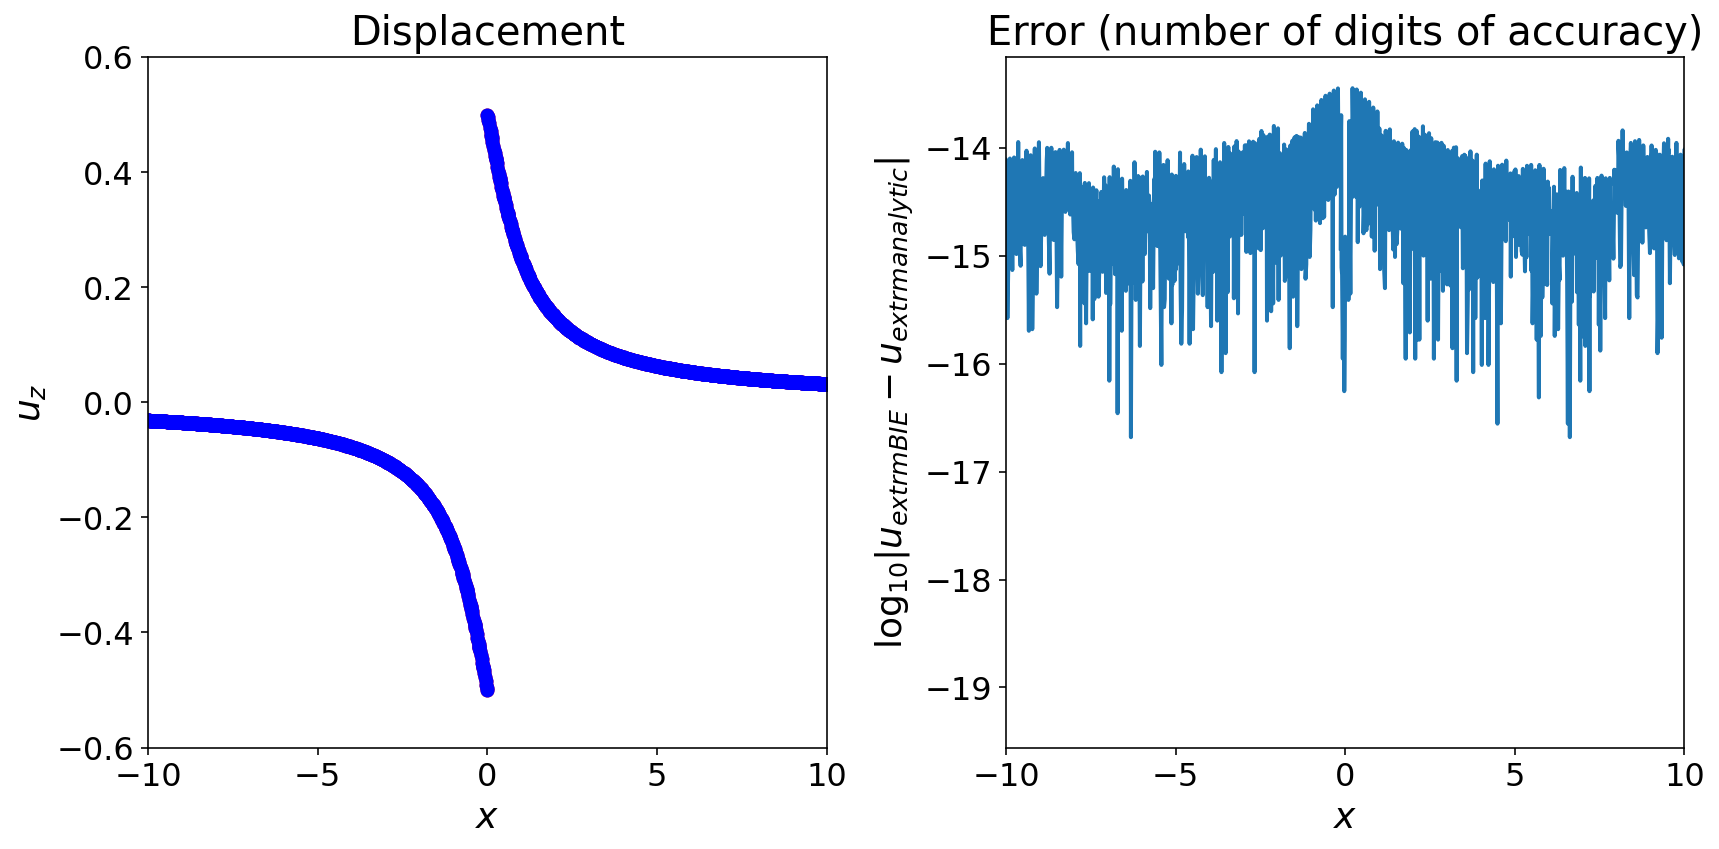

/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_50133/1958369183.py:83: RuntimeWarning: divide by zero encountered in log10
  plt.plot(free.pts[:, 0], np.log10(np.abs(surf_disp - analytical)))


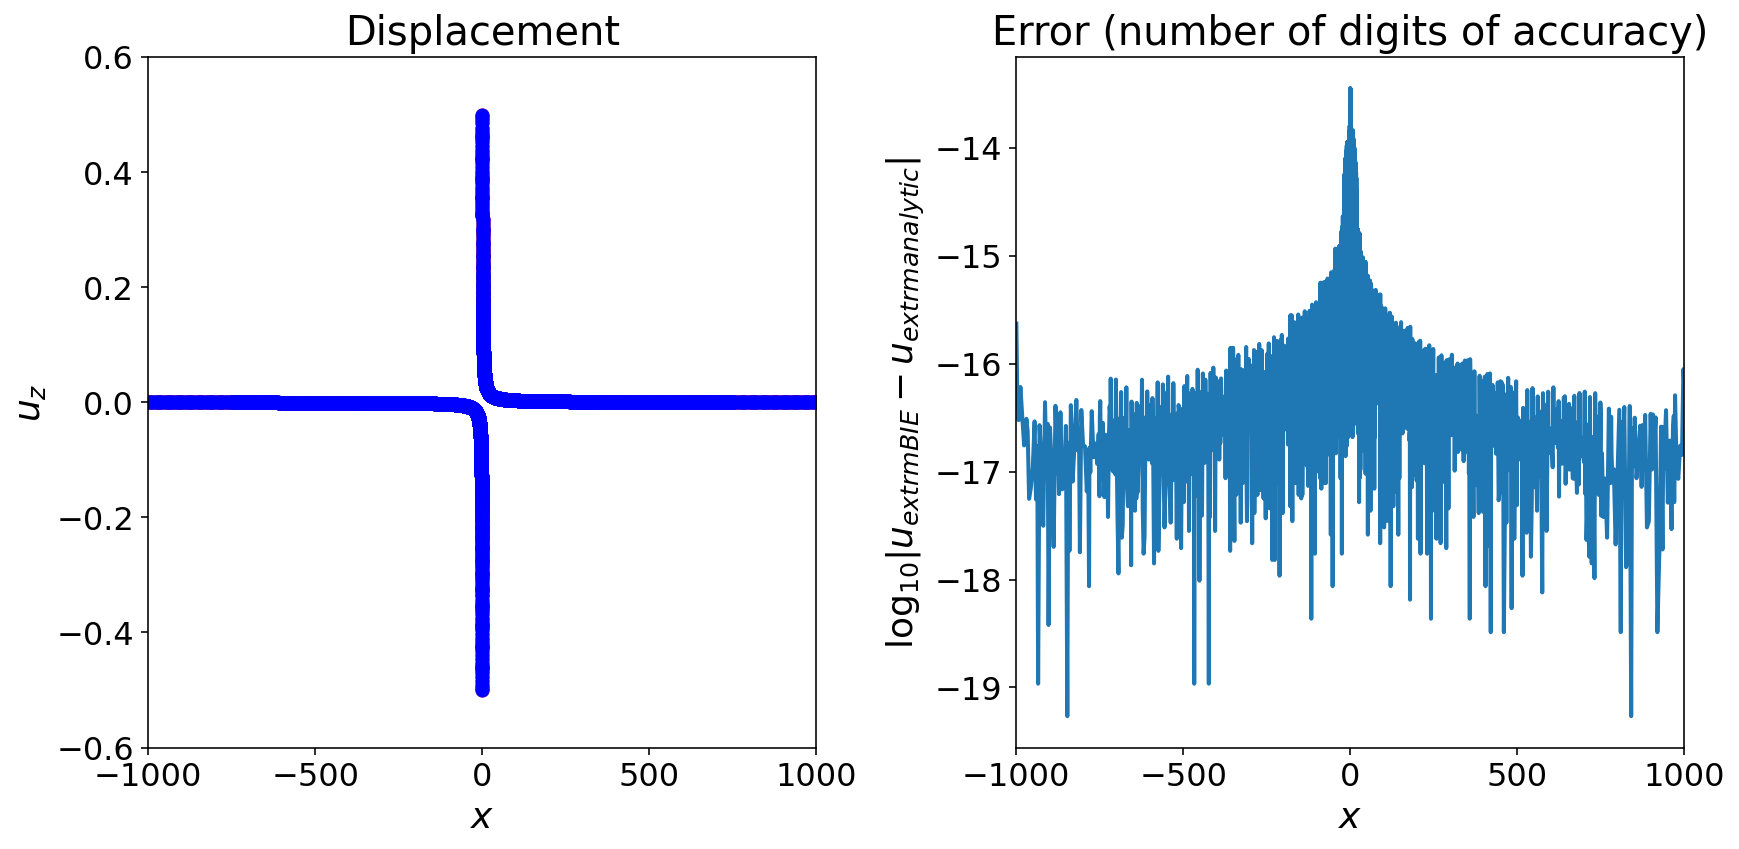

In [44]:
corner_resolution = 0.2
surf_half_L = 1000

qx, qw = gauss_rule(8)
t = sp.var("t")

fault, free = stage1_refine(
    [
        (t, t * 0, (t + 1) * -0.5),
        (t, -t * surf_half_L, 0 * t)
    ],
    (qx, qw),
    control_points=np.array([(0, 0, 10, corner_resolution)])
)

# The model has stress singularities. This is generally a sign that you should
# reconsider your modeling choices, but in this case it's okay because we're
# trying to match an existing analytical solution
# integrate_term does its best to handle known possible-singularities in the solution
# if the locations of the possible-singularities are provided
# Why do I call them possible-singularities?

# It's because any given point will only be a singularity for some choices of slip field.
# For example, the fault tip will produce a stress singularity for any slip distribution
# that is non-zero at the tip. But, if the slip field happens to be exactly zero at the 
# fault tip, then there is no singularity. But, the integration algorithm is producing a
# matrix that can be used for arbitrary slip distributions, so, for safety's sake, we need
# to assume that any "possible-singularity" will be a singularity. 

# In this model, there is a possible-singularity that turns out not to be a singularity:
# the fault-surface intersection. Here, either the step function in the surface displacement
# or the nonzero fault tip slip would cause a stress singularity on its own. But, when combined
# the singularities produced by these two features exactly cancel, leaving behind an entirely
# non-singular displacement field.
singularities = np.array([
    [-surf_half_L,0],
    [surf_half_L,0],
    [0,0],
    [0,-1],
])

(A,B), reports = integrate_term(
    double_layer,
    free.pts, 
    free,
    fault,
    singularities=singularities,
    return_report=True
)
A = A[:,0,:]
B = B[:,0,:]

print(free.n_pts, fault.n_pts)
# print(reports['p'])
# print(reports['integration_failed'])
# print(reports['n_subsets'])

lhs = np.eye(A.shape[0]) + A
slip = np.ones(fault.n_pts)
rhs = -B.dot(slip)
surf_disp = np.linalg.solve(lhs, rhs)

# Note that the analytical solution is slightly different than in the buried
# fault setting because we need to take the limit of an arctan as the
# denominator of the argument  goes to zero.
s = 1.0
analytical_fnc = lambda x: -np.arctan(-1 / x) / np.pi
analytical = analytical_fnc(free.pts[:,0])
%matplotlib inline
for XV in [10, 1000]:
    # XV = 5 * corner_resolution
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(free.pts[:, 0], surf_disp, "ro")
    plt.plot(free.pts[:, 0], analytical, "bo")
    plt.xlabel("$x$")
    plt.ylabel("$u_z$")
    plt.title("Displacement")
    plt.xlim([-XV, XV])
    plt.ylim([-0.6, 0.6])

    plt.subplot(1, 2, 2)
    plt.plot(free.pts[:, 0], np.log10(np.abs(surf_disp - analytical)))
    plt.xlabel("$x$")
    plt.ylabel("$\log_{10}|u_{\textrm{BIE}} - u_{\textrm{analytic}}|$")
    plt.title("Error (number of digits of accuracy)")
    plt.tight_layout()
    plt.xlim([-XV, XV])
    plt.show()

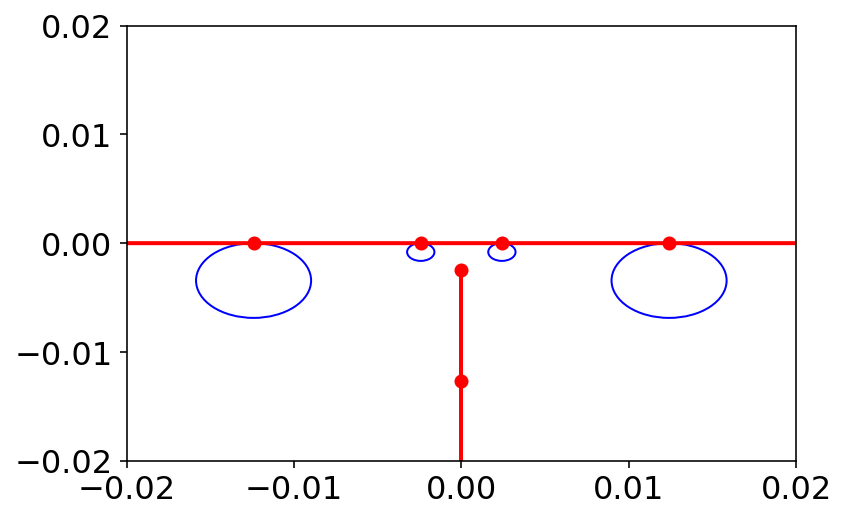

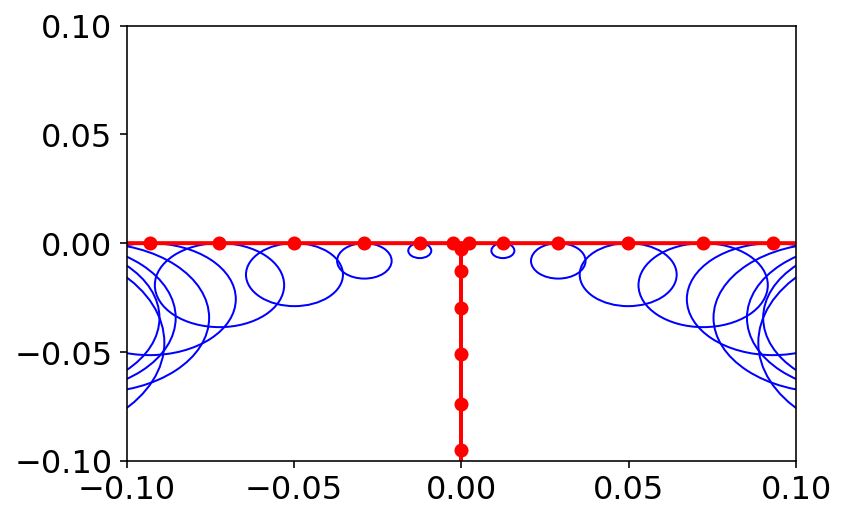

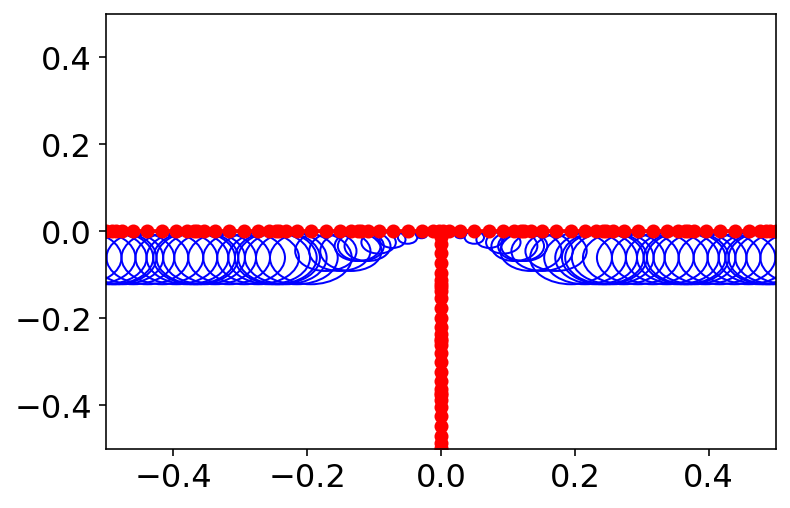

In [45]:
for V in [0.02, 0.1, 0.5]:
    cs = reports['exp_centers']
    rs = reports['exp_rs']
    plt.plot(fault.pts[:,0], fault.pts[:,1], 'r-o')
    plt.plot(free.pts[:,0], free.pts[:,1], 'r-o')
    for i in range(cs.shape[0]):
        plt.gca().add_patch(plt.Circle(cs[i], rs[i], color='b', fill=False))
    plt.xlim([-V, V])
    plt.ylim([-V, V])
    plt.show()

/Users/tbent/Dropbox/active/eq/tectosaur2/tectosaur2/integrate.py:143: UserWarning: Some expanded integrals reached maximum expansion order. These integrals may be inaccurate.
  warnings.warn(


p really high in 100 cases
maximum number of subsets required by adaptive integration:  2003


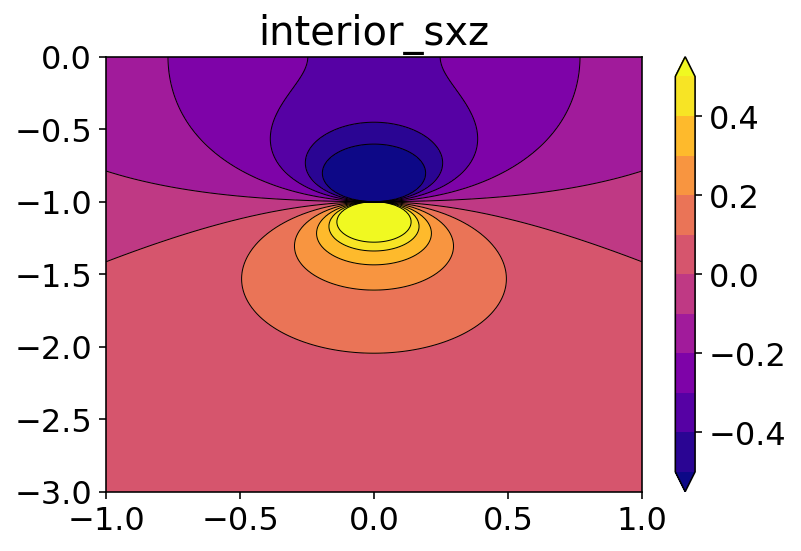

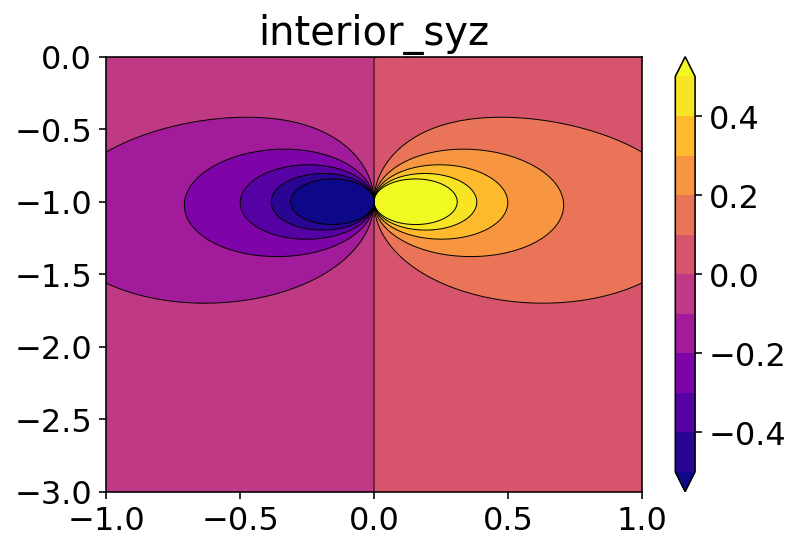

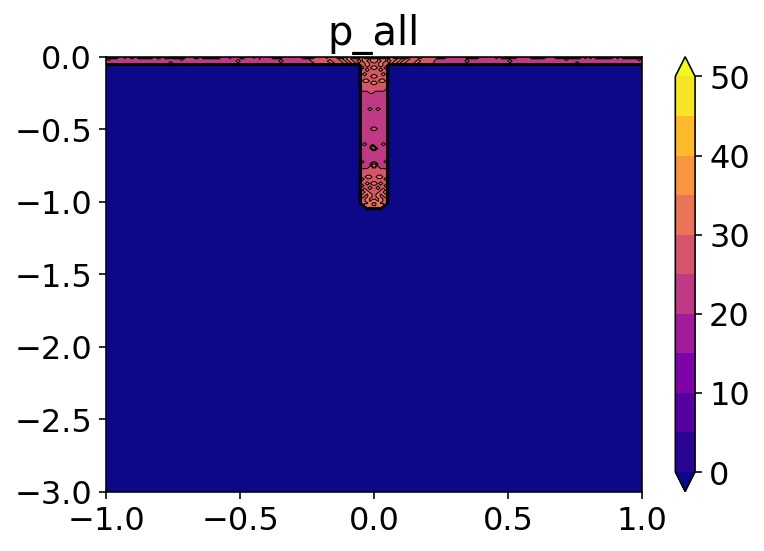

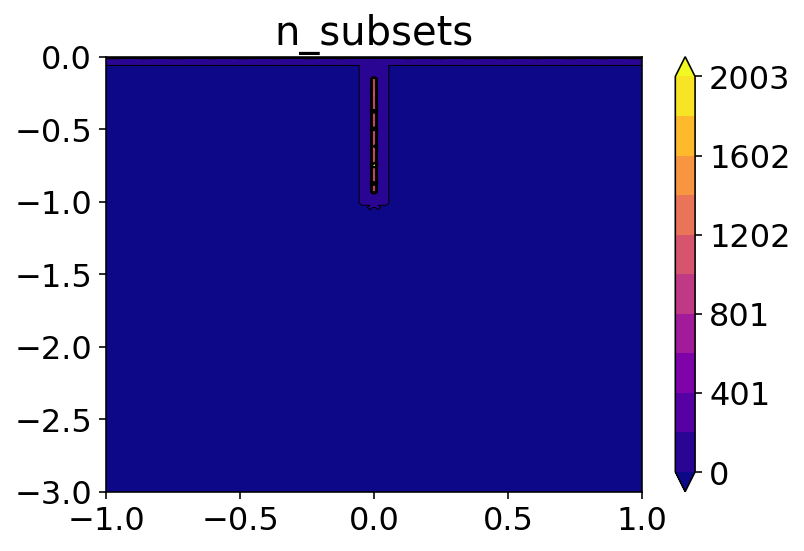

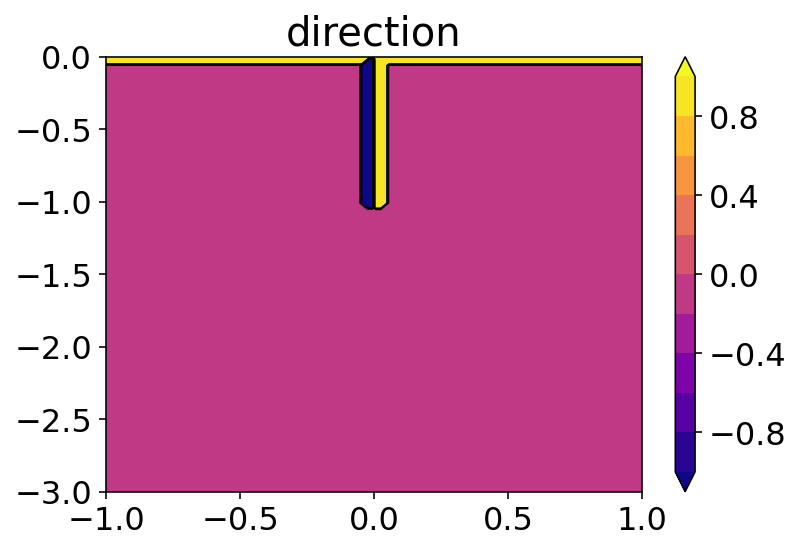

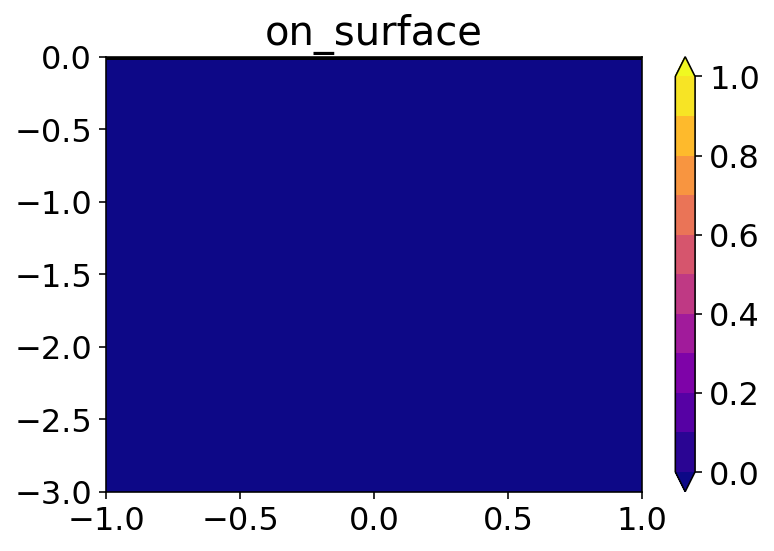

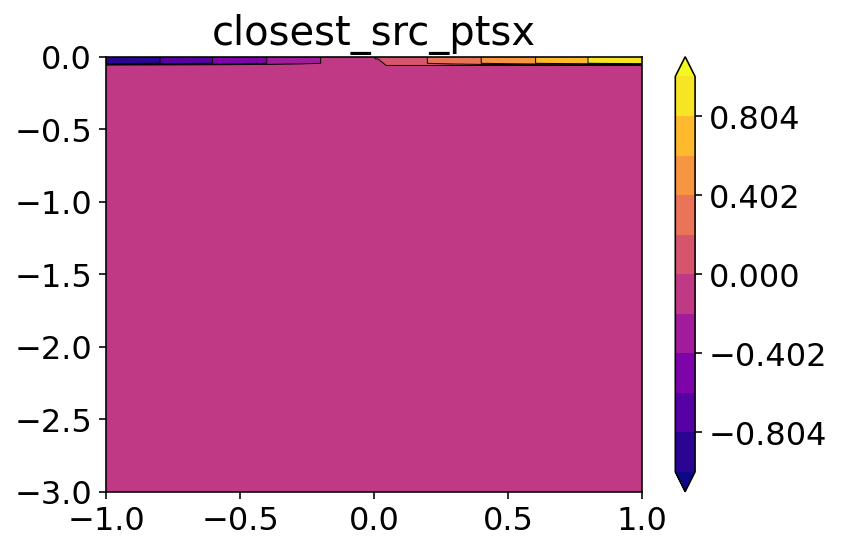

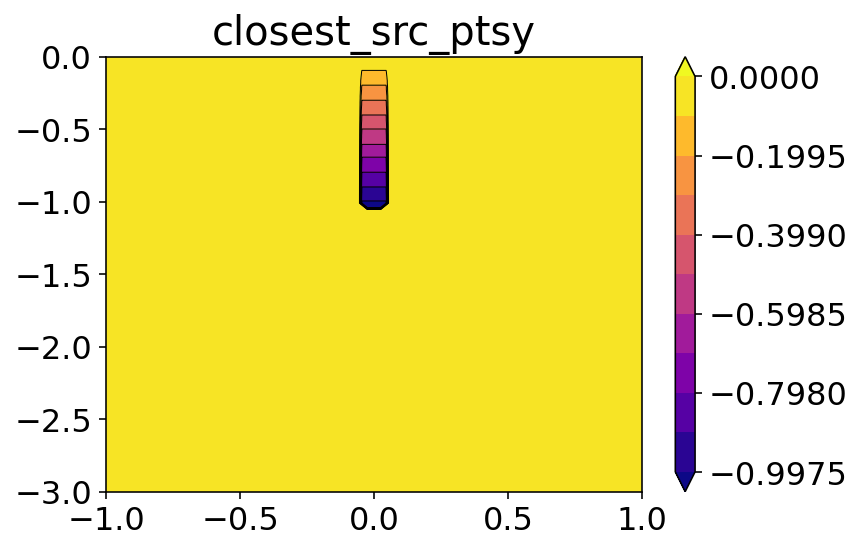

In [46]:
from tectosaur2.mesh import pts_grid, upsample
from tectosaur2.laplace2d import double_layer

plt.rcParams['text.usetex'] = False
nobs = 200
zoomx = [-1.0, 1.0]
zoomy = [-3, 0]
# nobs = 20
# zoomx = [-0.005, 0.005]
# zoomy = [-0.02, 0.0]
xs = np.linspace(*zoomx, nobs)
ys = np.linspace(*zoomy, nobs)
obs_pts = pts_grid(xs, ys)
obs_pts.shape

from tectosaur2.laplace2d import single_layer, hypersingular

K = hypersingular
(free_to_stress, fault_to_stress), report = integrate_term(
    K,
    obs_pts,
    free,
    fault,
    tol=5e-13,
    limit_direction=1.0,
    singularities=singularities,
    return_report=True,
)
interior_sxz = free_to_stress[:, 0, :].dot(surf_disp) + fault_to_stress[:, 0, :].dot(slip)
interior_syz = free_to_stress[:, 1, :].dot(surf_disp) + fault_to_stress[:, 1, :].dot(slip)
print("p really high in", np.sum(report["p"] > 40), "cases")
print(
    "maximum number of subsets required by adaptive integration: ",
    report["n_subsets"].max(),
)
n_subsets = np.zeros(obs_pts.shape[0])
n_subsets[report["use_qbx"]] = report["n_subsets"]

p_all = np.zeros(obs_pts.shape[0])
p_all[report["use_qbx"]] = report["p"]

direction = np.zeros(obs_pts.shape[0])
direction[report["use_qbx"]] = report["direction"]

on_surface = np.zeros(obs_pts.shape[0])
on_surface[report["use_qbx"]] = report["on_surface"]

closest_src_pts = np.zeros((obs_pts.shape[0], 2))
closest_src_pts[report["use_qbx"]] = report["closest_src_pts"]
closest_src_ptsx = closest_src_pts[:,0]
closest_src_ptsy = closest_src_pts[:,1]

for i, k in enumerate(
    [
        "interior_sxz",
        "interior_syz",
        "p_all",
        "n_subsets",
        "direction",
        "on_surface",
        "closest_src_ptsx",
        "closest_src_ptsy",
    ]
):
    plt.title(k)
    v = locals()[k].reshape((nobs, nobs))
    if i <= 1:
        levels = np.linspace(-0.5, 0.5, 11)
    else:
        levels = np.linspace(np.min(v), np.max(v), 11)
    cntf = plt.contourf(xs, ys, v, levels=levels, extend="both")
    plt.contour(
        xs,
        ys,
        v,
        colors="k",
        linestyles="-",
        linewidths=0.5,
        levels=levels,
        extend="both",
    )
    plt.colorbar(cntf)
    # plt.xlim([-0.01, 0.01])
    # plt.ylim([-0.02, 0.0])
    plt.show()


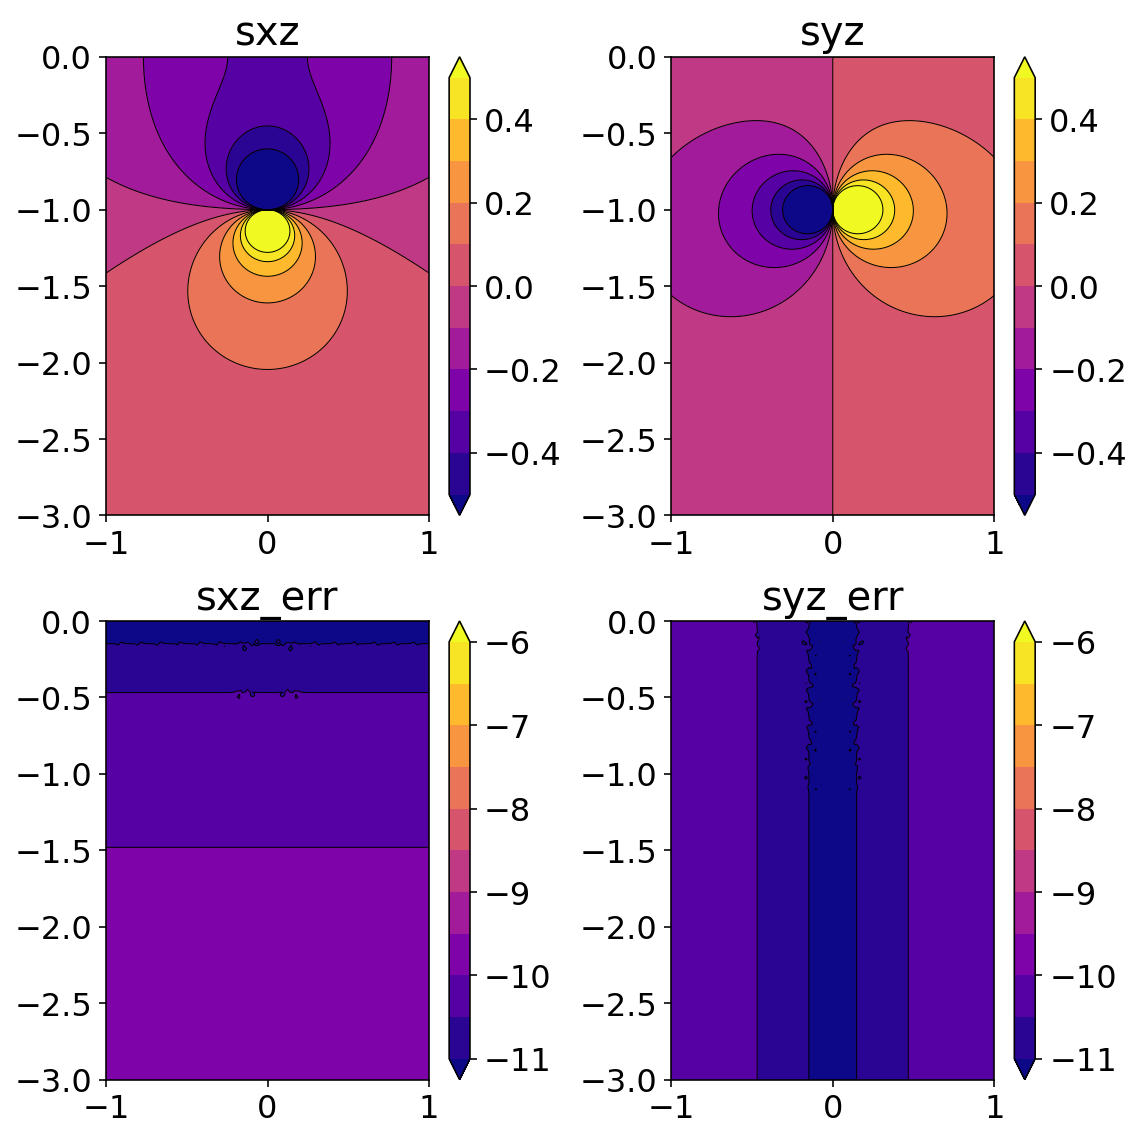

In [31]:
obsx = obs_pts[:,0]
obsy = obs_pts[:,1]
rp = obsx ** 2 + (obsy + 1) ** 2
ri = obsx ** 2 + (obsy - 1) ** 2
C = 1.0 / (2 * np.pi)
sxz = -C * (((obsy + 1) / rp) - ((obsy - 1) / ri))
syz = C * ((obsx / rp) - (obsx / ri))
sxz_err = np.log10(np.abs(interior_sxz - sxz))
syz_err = np.log10(np.abs(interior_syz - syz))

plt.figure(figsize = (8,8))
for i, k in enumerate(["sxz", "syz"]):
    plt.subplot(2,2,1+i) 
    plt.title(k)
    v = locals()[k].reshape((nobs, nobs))
    v2d = v.reshape((nobs, nobs))
    levels = np.linspace(-0.5, 0.5, 11)
    cntf = plt.contourf(xs, ys, v2d, levels=levels, extend="both")
    plt.contour(
        xs,
        ys,
        v2d,
        colors="k",
        linestyles="-",
        linewidths=0.5,
        levels=levels,
        extend="both",
    )
    plt.colorbar(cntf)
    # plt.xlim([-0.01, 0.01])
    # plt.ylim([-0.02, 0.0])

for i, k in enumerate(["sxz_err", "syz_err"]):
    plt.subplot(2,2,3+i) 
    plt.title(k)
    v = locals()[k].reshape((nobs, nobs))
    v2d = v.reshape((nobs, nobs))
    levels = np.linspace(-11, -6, 11)
    cntf = plt.contourf(xs, ys, v2d, levels=levels, extend="both")
    plt.contour(
        xs,
        ys,
        v2d,
        colors="k",
        linestyles="-",
        linewidths=0.5,
        levels=levels,
        extend="both",
    )
    plt.colorbar(cntf)
    # plt.xlim([-0.01, 0.01])
    # plt.ylim([-0.02, 0.0])
plt.tight_layout()
plt.show()



In [32]:
np.sum(report['p'] >= 50)

92

In [33]:
np.sum(report['n_subsets'] > 100)

306

In [34]:
np.max(sxz_err), np.max(syz_err)

(-9.693282366188, -10.163790901107793)

In [35]:
np.mean(sxz_err), np.mean(syz_err)

(-10.129740652887248, -10.601493624108521)